In [18]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_curve, auc,
                           precision_score, recall_score, f1_score)
from sklearn.impute import SimpleImputer

In [19]:
# Load the dataset
data = pd.read_csv('datasets/oasis_cross-sectional.csv')

# Display basic information
print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

# Check data types and missing values
print("\nData info:")
print(data.info())

# Statistical summary
print("\nStatistical summary:")
print(data.describe())

# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())

Dataset shape: (436, 12)

First 5 rows:
              ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3  OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  NaN  1588  0.803  1.105   
4  OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  NaN  1737  0.848  1.010   

   Delay  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-nul


Class distribution:
Alzheimer
0.0    336
1.0    100
Name: count, dtype: int64


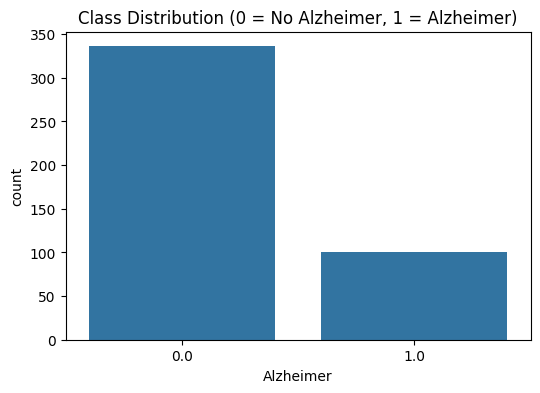

In [20]:
# Create binary target variable (Alzheimer's diagnosis)
data['Alzheimer'] = data['CDR'].apply(lambda x: 1 if x > 0 else 0)

# Drop unnecessary columns
data = data.drop(['ID', 'Delay', 'CDR'], axis=1)

# Handle missing values
# Separate numerical and categorical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Impute numerical columns with median
num_imputer = SimpleImputer(strategy='median')
data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])

# Impute categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])

# Convert categorical variables to numerical using one-hot encoding
data = pd.get_dummies(data, columns=['M/F', 'Hand'], drop_first=True)

# Check class distribution
print("\nClass distribution:")
print(data['Alzheimer'].value_counts())

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Alzheimer', data=data)
plt.title('Class Distribution (0 = No Alzheimer, 1 = Alzheimer)')
plt.show()

In [21]:
# Separate features and target
X = data.drop('Alzheimer', axis=1)
y = data['Alzheimer']

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)


Training set shape: (305, 8)
Testing set shape: (131, 8)


Random Forest Baseline Performance:
Accuracy: 0.8854961832061069

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93       101
         1.0       0.74      0.77      0.75        30

    accuracy                           0.89       131
   macro avg       0.84      0.84      0.84       131
weighted avg       0.89      0.89      0.89       131



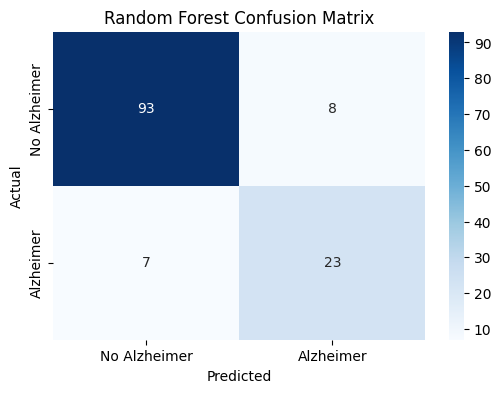

In [22]:
# Initialize and train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate performance
print("Random Forest Baseline Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Alzheimer', 'Alzheimer'],
            yticklabels=['No Alzheimer', 'Alzheimer'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

XGBoost Baseline Performance:
Accuracy: 0.8702290076335878

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92       101
         1.0       0.72      0.70      0.71        30

    accuracy                           0.87       131
   macro avg       0.82      0.81      0.81       131
weighted avg       0.87      0.87      0.87       131



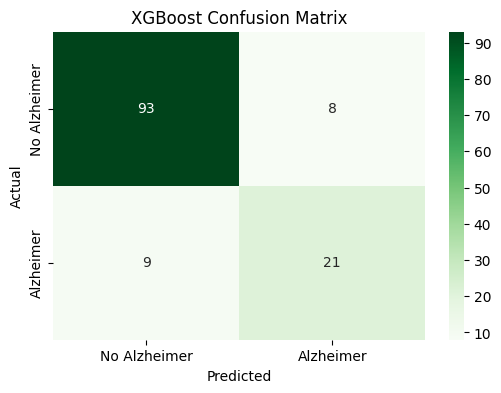

In [30]:
# Initialize and train XGBoost
xgb = XGBClassifier(
    tree_method='auto',
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test_scaled)

# Evaluate performance
print("XGBoost Baseline Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Alzheimer', 'Alzheimer'],
            yticklabels=['No Alzheimer', 'Alzheimer'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Tuned Random Forest Performance:
Accuracy: 0.8854961832061069

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       101
         1.0       0.76      0.73      0.75        30

    accuracy                           0.89       131
   macro avg       0.84      0.83      0.84       131
weighted avg       0.88      0.89      0.88       131



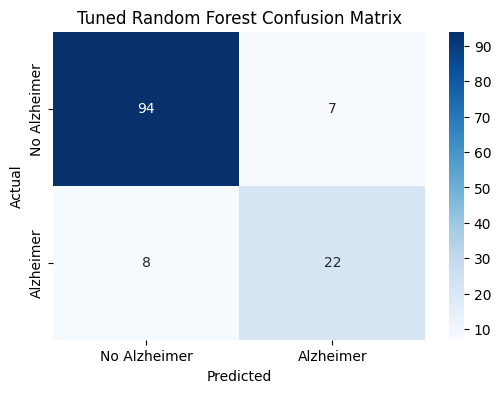

In [24]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_rf.fit(X_train_scaled, y_train)

# Show best parameters
print("Best Random Forest Parameters:", grid_rf.best_params_)

# Evaluate tuned model
best_rf = grid_rf.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test_scaled)

print("\nTuned Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_tuned))

# Confusion Matrix
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Alzheimer', 'Alzheimer'],
            yticklabels=['No Alzheimer', 'Alzheimer'])
plt.title('Tuned Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

Tuned XGBoost Performance:
Accuracy: 0.8702290076335878

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92       101
         1.0       0.72      0.70      0.71        30

    accuracy                           0.87       131
   macro avg       0.82      0.81      0.81       131
weighted avg       0.87      0.87      0.87       131



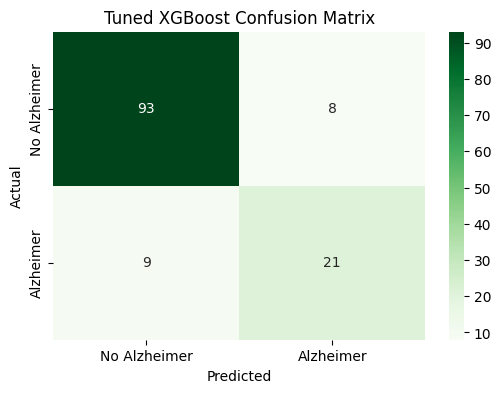

In [31]:
# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search
grid_xgb = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_xgb.fit(X_train_scaled, y_train)

# Show best parameters
print("Best XGBoost Parameters:", grid_xgb.best_params_)

# Evaluate tuned model
best_xgb = grid_xgb.best_estimator_
y_pred_xgb_tuned = best_xgb.predict(X_test_scaled)

print("\nTuned XGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_tuned))

# Confusion Matrix
cm_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Alzheimer', 'Alzheimer'],
            yticklabels=['No Alzheimer', 'Alzheimer'])
plt.title('Tuned XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

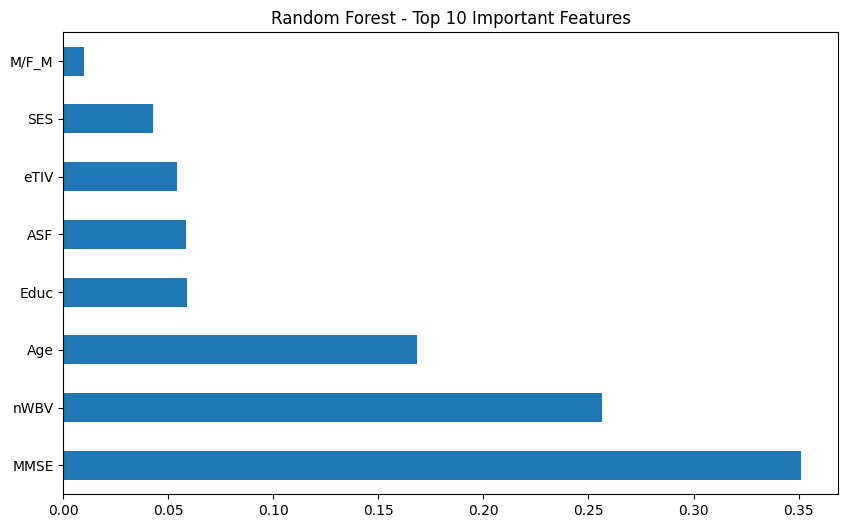

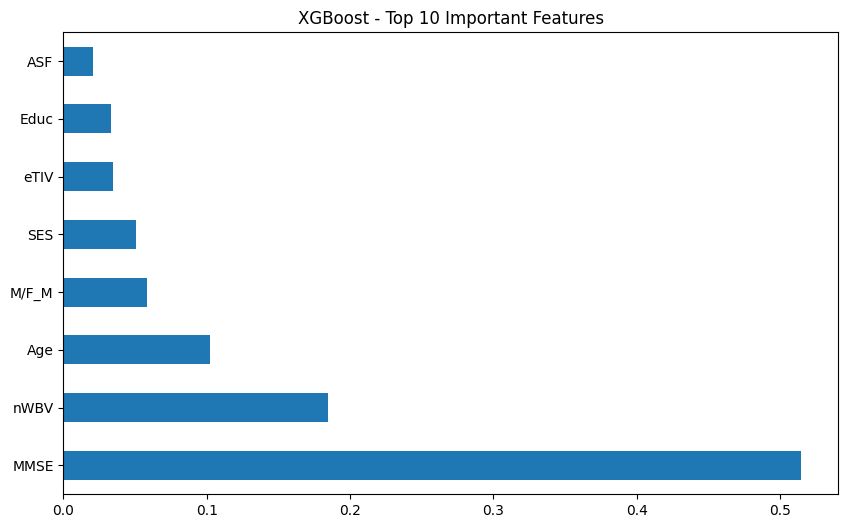

In [26]:
# Random Forest Feature Importance
plt.figure(figsize=(10, 6))
feat_importances_rf = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_importances_rf.nlargest(10).plot(kind='barh')
plt.title('Random Forest - Top 10 Important Features')
plt.show()

# XGBoost Feature Importance
plt.figure(figsize=(10, 6))
feat_importances_xgb = pd.Series(best_xgb.feature_importances_, index=X.columns)
feat_importances_xgb.nlargest(10).plot(kind='barh')
plt.title('XGBoost - Top 10 Important Features')
plt.show()

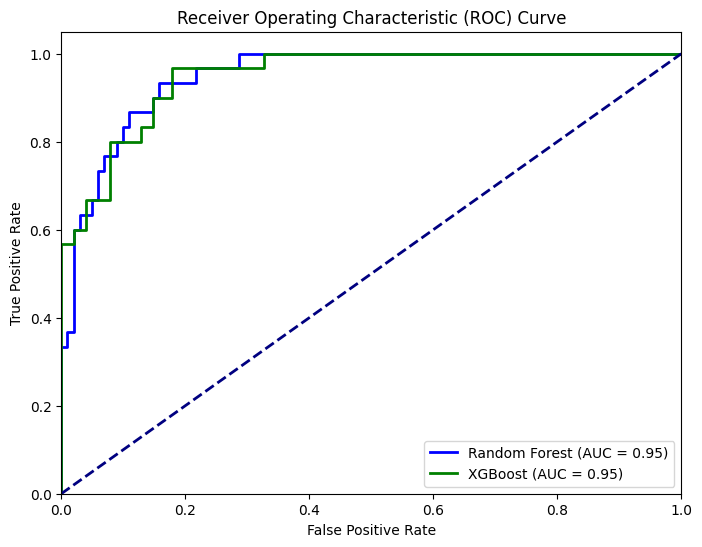


Model Comparison:
                   Model  Accuracy  Precision    Recall  F1-Score
0          Random Forest  0.885496   0.741935  0.766667  0.754098
1  Random Forest (Tuned)  0.885496   0.758621  0.733333  0.745763
2                XGBoost  0.870229   0.724138  0.700000  0.711864
3        XGBoost (Tuned)  0.870229   0.724138  0.700000  0.711864


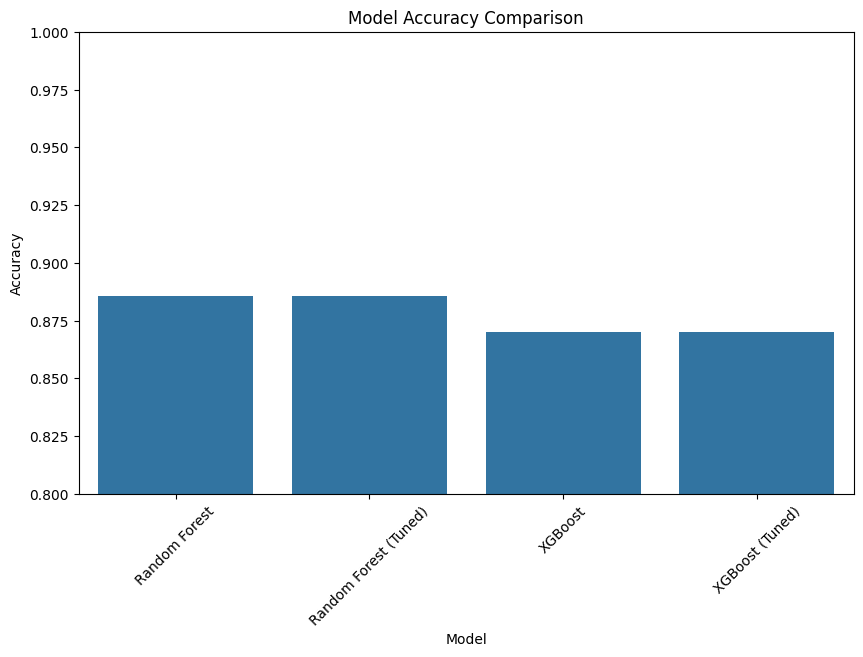

In [27]:
# Calculate ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test_scaled)[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb.predict_proba(X_test_scaled)[:,1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Random Forest (Tuned)', 'XGBoost', 'XGBoost (Tuned)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_rf_tuned),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_xgb_tuned)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf_tuned),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_xgb_tuned)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf_tuned),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_xgb_tuned)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf_tuned),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_xgb_tuned)
    ]
})

print("\nModel Comparison:")
print(comparison)

# Visual comparison of accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison)
plt.title('Model Accuracy Comparison')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45)
plt.show()

In [28]:
# Determine the best model
best_model = comparison.loc[comparison['Accuracy'].idxmax()]
print(f"\nThe best model is {best_model['Model']} with:")
print(f"- Accuracy: {best_model['Accuracy']:.4f}")
print(f"- Precision: {best_model['Precision']:.4f}")
print(f"- Recall: {best_model['Recall']:.4f}")
print(f"- F1-Score: {best_model['F1-Score']:.4f}")


The best model is Random Forest with:
- Accuracy: 0.8855
- Precision: 0.7419
- Recall: 0.7667
- F1-Score: 0.7541


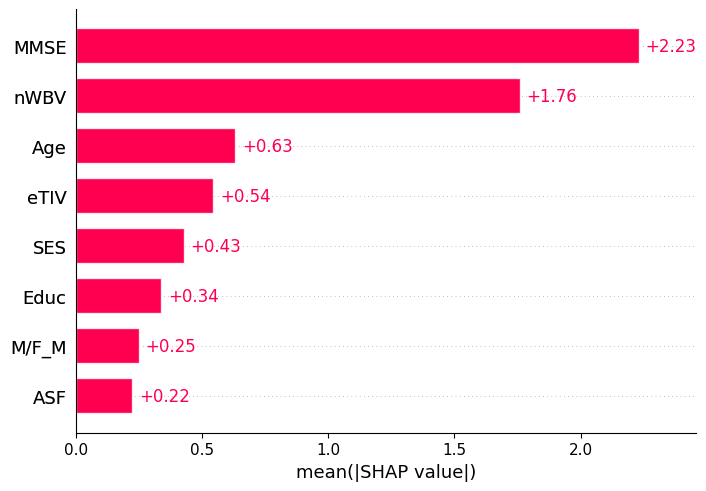

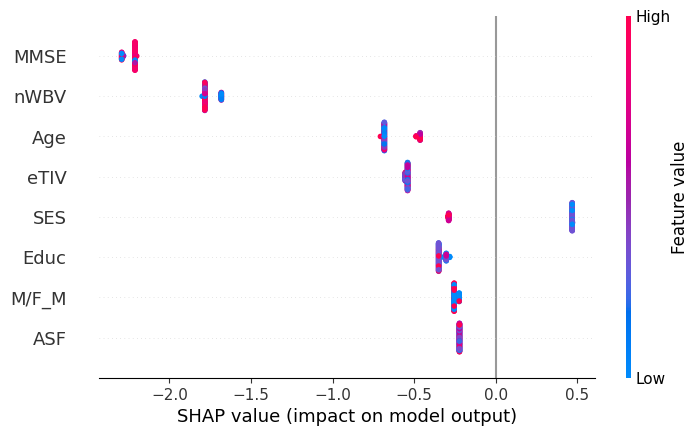

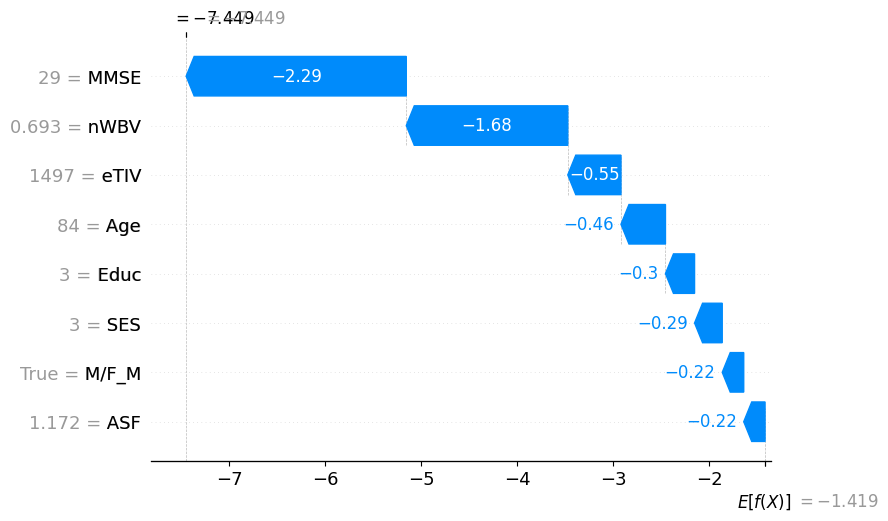

In [32]:

import shap

# Initialize the explainer
explainer = shap.Explainer(xgb)

# Compute SHAP values
shap_values = explainer(X_test)

# Global feature importance plot
shap.plots.bar(shap_values)

# Summary plot (beeswarm)
shap.plots.beeswarm(shap_values)

# Explanation for a single prediction
sample_index = 0  # change index to explain other samples
shap.plots.waterfall(shap_values[sample_index])
